# Decision Tree Pipeline


## Decision Tree Modeling and Analysis

### This file is a pipeline of Logistic Regression modeling and subsequent interpretation of the model. 

The Pipeline will be as follows:

1. Read the data in with custom function built at the end of the `Baseball_EDA` notebook.
2. Build a Pipeline object with two components: a random undersampler and the classification model. Random Undersampler was chosen due to imbalance of the target classes. 
3. Fit the pipeline to training data and verify results using 5-fold cross validation. This process will use custom function in the `Evaluation.py` module. 
4. Visualize the tree and analize its output. 
5. Apply the pipeline to testing data to get test results that will be compared with other models. 

In [7]:
#start with all dependencies

import numpy as np
import pandas as pd
from Evaluation import *
from data_import import prepare_data
import sklearn
import sklearn.metrics as metrics
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
from sklearn.preprocessing import Imputer
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline, make_pipeline
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt
%matplotlib inline
import imblearn
import seaborn as sns
sns.set()
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
#Read in the data as pandas dataframe
file = '../Statcast_data.csv'

#define bsb as the full dataframe
bsb = prepare_data('../Statcast_data.csv')

#filter out the predictors and the target
X = bsb.drop(columns = ['player_name', 'description'])
y = bsb['description']

#quick look to see above worked. 
X.head()



,release_spin_rate,release_pos_x,release_pos_y,release_pos_z,vx0,vz0,vy0,sz_top,sz_bot,pitch_L,pitch_R,pitch_2-Seam Fastball,pitch_4-Seam Fastball,pitch_Changeup,pitch_Curveball,pitch_Cutter,pitch_Sinker,pitch_Slider,pitch_Split Finger
0,2314.0,3.2655,54.4995,5.2575,-9.8035,0.1339,-138.1130,3.2971,1.5059,1,0,1,0,0,0,0,0,0,0
1,2324.0,3.1728,54.3094,5.3966,-9.0084,-2.4218,-140.5865,3.3136,1.5730,1,0,0,1,0,0,0,0,0,0
2,2521.0,3.3517,55.0820,5.1205,-3.7285,1.2140,-117.3223,3.9119,1.7080,1,0,0,0,0,0,0,0,1,0
3,2329.0,3.1334,54.0207,5.2136,-12.0533,-5.1407,-139.3669,3.5553,1.5639,1,0,0,1,0,0,0,0,0,0
4,2437.0,3.3033,54.3597,5.0589,-14.0287,-3.3434,-139.8559,3.3450,1.6241,1,0,0,1,0,0,0,0,0,0


# Decision Tree

In [4]:
#split the data into training and testing splits
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 777)

#build the pipeline object
#will build a depth of 4, in order to allow us to visualize it
tree = DecisionTreeClassifier(max_depth=4)
sampler = RandomUnderSampler(ratio = 1, random_state=777)

tree_pipe = make_pipeline(sampler, tree)

tree_pipe_results = cross_validate(tree_pipe, X_train, y_train, 
                            scoring = ['accuracy', 'f1', 'roc_auc'], 
                            cv =5, return_estimator=True, return_train_score = True)

for result in ['train_accuracy', 'test_accuracy', 'train_f1', 'test_f1', 'train_roc_auc', 'test_roc_auc']:
    print(f"Mean {result} Value: {np.mean(tree_pipe_results[result])}")
    print(f"{result} scores: {tree_pipe_results[result]}")
    print() 

Mean train_accuracy Value: 0.47754788645775026
train_accuracy scores: [0.44538435 0.4524073  0.44732126 0.59086357 0.45176294]

Mean test_accuracy Value: 0.47556549358653866
test_accuracy scores: [0.43981237 0.4544113  0.4472963  0.58711922 0.44918828]

Mean train_f1 Value: 0.4993219216893081
train_f1 scores: [0.51701664 0.50881112 0.51269242 0.44546835 0.51262109]

Mean test_f1 Value: 0.49696350913552456
test_f1 scores: [0.5126324  0.50975564 0.51234597 0.43858392 0.51149963]

Mean train_roc_auc Value: 0.6030736715956055
train_roc_auc scores: [0.60770228 0.59914794 0.60257326 0.60359446 0.60235042]

Mean test_roc_auc Value: 0.6009185109336872
test_roc_auc scores: [0.60214381 0.60118836 0.59455065 0.59844926 0.60826048]



In [5]:
predictions = tree_pipe_results['estimator'][0].predict(X_test)

def eval_test_set(x_test_predictions, y_test):
    print(f"Accuracy Score: {metrics.accuracy_score(y_test, x_test_predictions)}")
    print()
    print(f"AUC Score: {metrics.roc_auc_score(y_test, x_test_predictions)}")
    print()
    print(f"F1 Score: {metrics.f1_score(y_test, x_test_predictions)}")
    print()
    print(f"Classification Report: \n {metrics.classification_report(y_test, x_test_predictions)}")
    print()
    print(f" Confustion Matrix: \n {metrics.confusion_matrix(y_test, x_test_predictions)}")

eval_test_set(predictions, y_test)



Accuracy Score: 0.4445182304019227

AUC Score: 0.5696775617494635

F1 Score: 0.5165941989102316

Classification Report: 
               precision    recall  f1-score   support

           0       0.85      0.22      0.35     21437
           1       0.36      0.92      0.52     10186

    accuracy                           0.44     31623
   macro avg       0.61      0.57      0.43     31623
weighted avg       0.69      0.44      0.40     31623


 Confustion Matrix: 
 [[ 4671 16766]
 [  800  9386]]


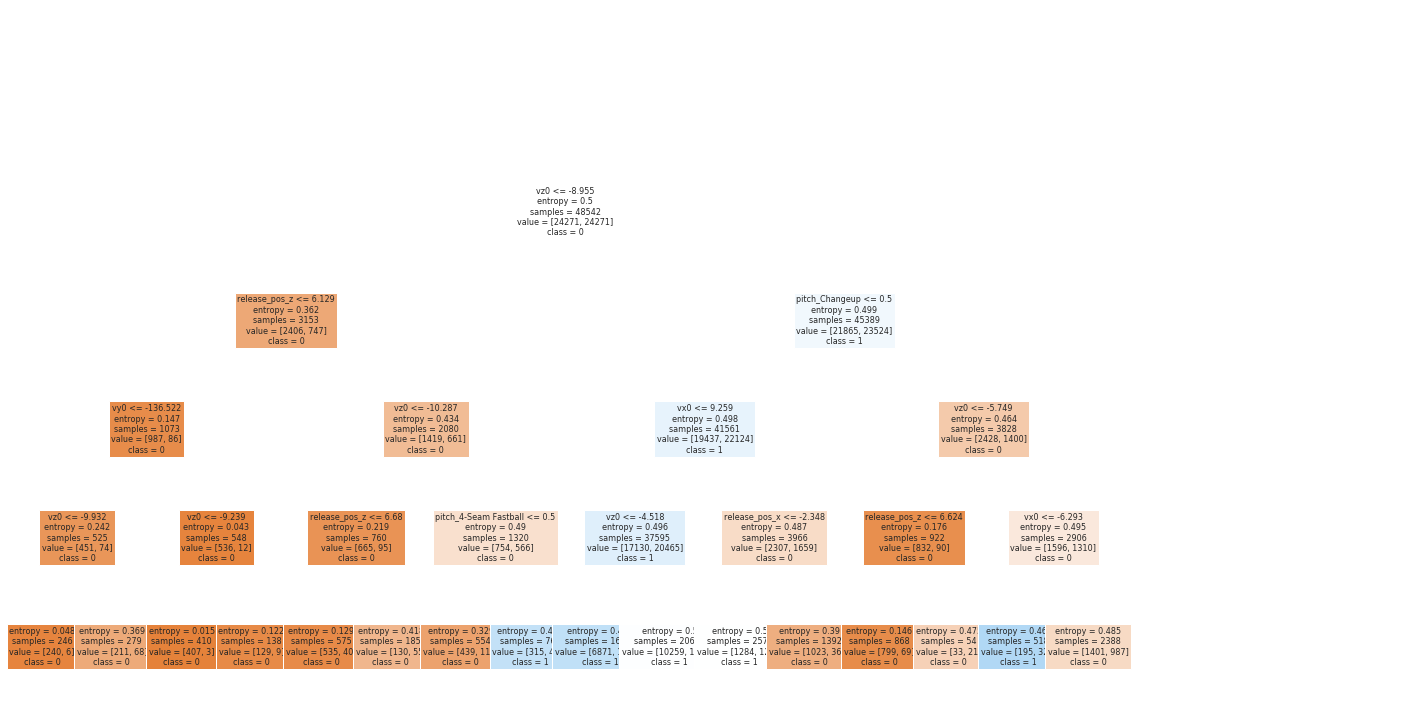

In [9]:
fig = plt.figure(figsize = (20, 10))
img = plot_tree(tree_pipe_results['estimator'][0][1], feature_names=X_train.columns, 
                class_names = ['0', '1'], filled=True, fontsize = 8, 
               )
plt.tight_layout()
fig.savefig('../images/Basic_decision_tree.png')


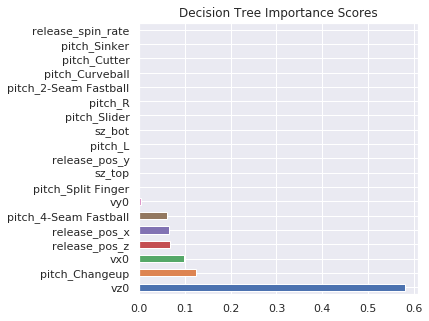

In [10]:
#show feature importances
fig = plt.figure(figsize = (5,5))
importances = pd.Series(tree_pipe_results['estimator'][0][1].feature_importances_, index=X_train.columns) \
.sort_values(ascending = False).plot(kind = 'barh', title='Decision Tree Importance Scores')
fig.savefig('../images/Basic_decision_tree_importance.png', bbox_inches = 'tight')

## Interpretation

This decision tree is showing that there are only a few informative features, including 'vz0', 'vx0' and two release position attributes. The velocity of the ball in the z dimension is the strongest predictor, as it is the first node. What we can infer from this is that if the ball has a velocity in the z-dimension that is too negatively large, i.e. it is going downward at too fast a rate, it is predicted as ball, which makes sense. The tree appears to be better able to predict a ball than a strike. 

As for deciding if the pitch is classified as a strike, if the pitch is not moving downward at that velocity and the pitch is not deemed a changeup, this appears to be one of the most important conditions. Additionally, it thinks that if the above two conditions are also true, and if the velocity in the x-dimension, or the lateral movement (from the catcher's perspective) is below 9.26 ft/s moving to the right, then the model will classify it as a strike. Still, we intuitevly know that for features involved with a pitch like movement of the pitch, there is more likely a range of values that are key indicators, not just a threshold value. Trying to determine key ranges of values for features is difficult in a decision tree. 

We must also keep in mind that the performance of this individual model is very weak. Part of the reason for this is that in order to visualize a tree, the depth of the tree must be limited in order for it to be interpreted by a human subject. This limiting of the tree and its subsequent lack of performance is supported by the sample sizes in various splits in the diagram above. The tree is much better at choosing splitting points for classifying a called ball; the entropy values for numerous nodes are much lower for called balls than entropy values for called strikes. Thus, there is a catch-22: in order to trust that the results our single decision tree provides us, we would want to visualize it and ensure that it's splitting points are appropriate. However, in order to do so, the depth of the tree has to be limited to a value so as to allow a tree to be visualized and understood. This limitation can hinder the performance of the tree, and thus with a lower peformance, we will be less trustworthy of accepting the information that the tree can give us. 



In [11]:
predictions = tree_pipe_results['estimator'][0].predict(X_test)

eval_test_set(predictions, y_test)



Accuracy Score: 0.4445182304019227

AUC Score: 0.5696775617494635

F1 Score: 0.5165941989102316

Classification Report: 
               precision    recall  f1-score   support

           0       0.85      0.22      0.35     21437
           1       0.36      0.92      0.52     10186

    accuracy                           0.44     31623
   macro avg       0.61      0.57      0.43     31623
weighted avg       0.69      0.44      0.40     31623


 Confustion Matrix: 
 [[ 4671 16766]
 [  800  9386]]
